In [1]:
%load_ext autoreload
%autoreload 2

Currently, to run this tutorial, you'll have to clone the CLIMADA repo:

```
git clone https://github.com/CLIMADA-project/climada_python.git
cd climada_python
```

Then from within the repo folder:

```
mamba create -n climada_MCA "python==3.11.*"
git fetch
git checkout feature/MCDM
mamba env update -n climada_MCA -f requirements/env_climada.yml
mamba activate climada_MCA
python -m pip install ./

```

In [2]:
import time
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, box
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from climada.entity import Exposures
from climada.hazard import Hazard, Centroids

import json


def save_impact_funcs_to_json(impact_funcs, filename):
    """
    Saves a list of climada.entity.ImpactFunc objects to a JSON file.

    This function handles the conversion of numpy arrays within the objects
    to standard Python lists, making them JSON-serializable.

    Args:
        impact_funcs (list): A list of ImpactFunc objects to save.
        filename (str): The name of the JSON file to create.
    """
    # List to hold the dictionaries of our impact functions
    impact_funcs_data = []

    # Iterate through each ImpactFunc object
    for impf in impact_funcs:
        # Create a dictionary from the object's attributes
        # Convert numpy arrays to lists for JSON serialization
        impf_dict = {
            "haz_type": impf.haz_type,
            "id": impf.id,
            "intensity": impf.intensity.tolist(),
            "mdd": impf.mdd.tolist(),
            "paa": impf.paa.tolist(),
            "intensity_unit": impf.intensity_unit,
            "name": impf.name,
        }
        impact_funcs_data.append(impf_dict)

    # Write the list of dictionaries to the JSON file
    try:
        with open(filename, "w") as f:
            json.dump(impact_funcs_data, f, indent=4)
        print(
            f"Successfully saved {len(impact_funcs)} impact functions to '{filename}'"
        )
    except IOError as e:
        print(f"An error occurred while writing to the file: {e}")


def load_impact_funcs_from_json(filename):
    """
    Loads a list of climada.entity.ImpactFunc objects from a JSON file.

    This function reads the data from the JSON file and converts the lists
    back into numpy arrays to properly reconstruct the ImpactFunc objects.

    Args:
        filename (str): The name of the JSON file to load from.

    Returns:
        list: A list of reconstructed ImpactFunc objects.
    """
    loaded_impact_funcs = []

    try:
        with open(filename, "r") as f:
            impact_funcs_data = json.load(f)

        # Iterate through the list of dictionaries from the file
        for impf_dict in impact_funcs_data:
            # Recreate the ImpactFunc object
            # Convert lists back to numpy arrays
            impf = ImpactFunc(
                haz_type=impf_dict["haz_type"],
                id=impf_dict["id"],
                intensity=np.array(impf_dict["intensity"]),
                mdd=np.array(impf_dict["mdd"]),
                paa=np.array(impf_dict["paa"]),
                intensity_unit=impf_dict["intensity_unit"],
                name=impf_dict["name"],
            )
            loaded_impact_funcs.append(impf)

        print(
            f"Successfully loaded {len(loaded_impact_funcs)} impact functions from '{filename}'"
        )
        return loaded_impact_funcs

    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{filename}'. File may be corrupted.")
        return []

In [3]:
data_path = Path("./DATA/MCA/")

# Define the Results folder inside the data path
results_path = data_path / "Results"

# Create the Results folder if it doesn't exist
results_path.mkdir(parents=True, exist_ok=True)

# Create all the data

## Inputs

### Population

In [176]:
import geopandas as gpd

roskilde_bounds = gpd.read_file(data_path / "roskilde_municipality_shape.geojson").loc[
    [0]
]
with rasterio.open(data_path / "Population/dnk_ppp_2020_UNadj_constrained.tif") as src:
    out_image, out_transform = mask(src, roskilde_bounds.geometry, crop=True)

    # Update the metadata of the new cropped raster
    out_meta = src.meta.copy()
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )

    # Save the cropped raster to a new file
    output_path = data_path / "Population/roskilde_ppp_2020_UNadj_constrained.tif"
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

    print(f"Successfully cropped WorldPop data and saved to {output_path}")

with rasterio.open(
    data_path / "Population/roskilde_ppp_2020_UNadj_constrained.tif"
) as src:
    metadata = src.profile

    print("--- Primary Metadata ---")
    for key, value in metadata.items():
        print(f"{key}: {value}")
    data = src.read(1)
    nodata_value = src.nodata

    # Replace the NoData values with np.nan
    data[data == nodata_value] = np.nan

Successfully cropped WorldPop data and saved to DATA/MCA/Population/roskilde_ppp_2020_UNadj_constrained.tif
--- Primary Metadata ---
driver: GTiff
dtype: float32
nodata: -99999.0
width: 338
height: 319
count: 1
crs: EPSG:4326
transform: | 0.00, 0.00, 11.97|
| 0.00,-0.00, 55.78|
| 0.00, 0.00, 1.00|
blockxsize: 338
blockysize: 6
tiled: False
interleave: band


### Exposure layer

Here we load building shapefiles from OSM. In general, most geographical formats can be read. The only required information is the "value" per location.

The surface in square meters was computed in QGIS, it should also be easy to do something similar with geopandas. We derive the "value" 

In addition we can define a "group_id" column (for instance it could correspond to the SVI index at that location).

Other index columns can also be usefull later if defined (building type for instance), the geodataframe is saved within the python object.

We save that exposure layer in a CLIMADA `Exposures` object as `exp_base`.

In [178]:
exp_gdf = gpd.read_file(data_path / "osm_buildings_roskilde_120705.geojson")
exp_gdf["value"] = exp_gdf["value_m2"] * exp_gdf["surface_m2"]
exp_polygons_base = exp_gdf.copy()
exp_gdf

svi = gpd.read_file("./DATA/MCA/Social_Sarbarheds_Index/SocialtSaarbarhedsIndex.shp")
svi.to_crs(exp_gdf.crs)
num_bins = 6
min_val = -3
max_val = 3
bins = np.linspace(min_val, max_val, num_bins + 1)
# Bin the data using pd.cut
svi["index_binned"] = pd.cut(
    svi["Z_svi_wins"], bins=bins, labels=False, include_lowest=True
)
original_crs = exp_gdf.crs
exp_gdf = exp_gdf.to_crs(svi.crs)
exp_gdf["geometry"] = exp_gdf["geometry"].centroid
exp_gdf = exp_gdf.sjoin_nearest(svi[["geometry", "index_binned"]], how="left")
exp_gdf = exp_gdf.to_crs(original_crs)
exp_gdf["group_id"] = exp_gdf["index_binned"]

In [191]:
exp_base = Exposures(
    exp_gdf[["value_m2", "surface_m2", "value", "group_id", "geometry"]]
)

In [192]:
exp_base.gdf

,value_m2,surface_m2,value,group_id,geometry
0,1000.0,411.398,411398.0,4,POINT (12.07886 55.64257)
1,1000.0,555.950,555950.0,4,POINT (12.07872 55.64228)
2,1000.0,194.597,194597.0,0,POINT (12.10450 55.66137)
3,1000.0,8493.276,8493276.0,4,POINT (12.05386 55.63429)
4,1000.0,223.471,223471.0,0,POINT (12.16067 55.66395)
...,...,...,...,...,...
22998,1000.0,1150.527,1150527.0,3,POINT (12.07659 55.63748)
22999,1000.0,315.392,315392.0,3,POINT (12.07394 55.62947)
23000,1000.0,1132.954,1132954.0,3,POINT (12.08553 55.64133)
23001,1000.0,683.985,683985.0,3,POINT (12.08157 55.63813)


In [193]:
exp_base.write_hdf5("./DATA/MCA/built_inputs/exposure_base_with_SVI.hdf5")

Then we build the exposure when considering coastal retreat. I built the shape file using QGIS.

We save that one in `exp_base_relocate`

In [10]:
relocation = gpd.read_file("./DATA/MCA/coastal_retreat_zone.geojson")

<Axes: >

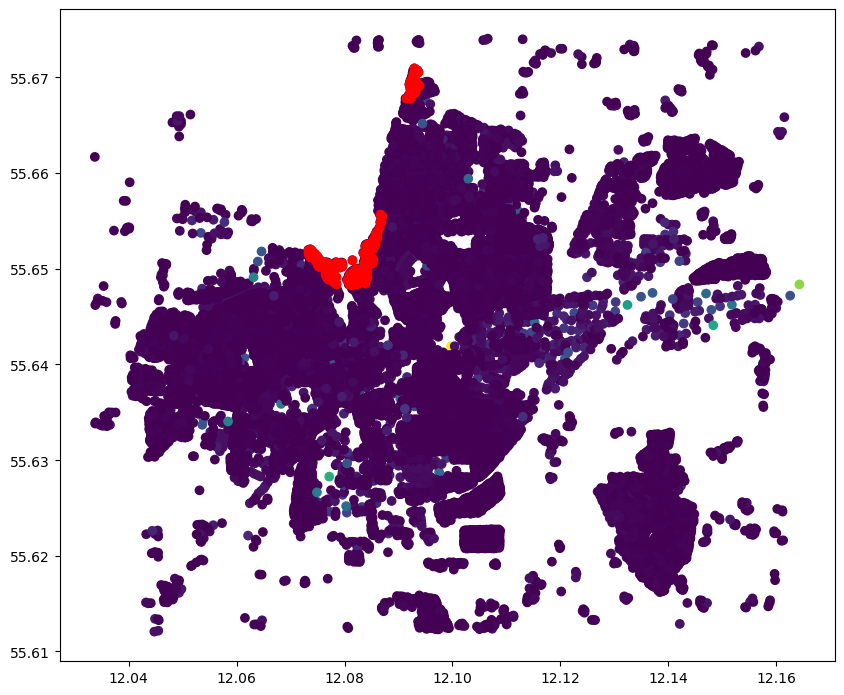

In [ ]:
exp_gdf = exp_base.gdf.copy()
to_remove = exp_gdf.sjoin(relocation, how="inner", predicate="within")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exp_gdf.plot(column="value", ax=ax)
exp_gdf.loc[to_remove.index].plot(color="red", ax=ax)

In [195]:
exp_gdf = exp_gdf.drop(to_remove.index)
exp_polygons_relocate = exp_gdf.copy()
exp_gdf["geometry"] = exp_gdf["geometry"].centroid
exp_gdf["group_id"] = exp_base.gdf.loc[exp_gdf.index, "group_id"]
exp_base_relocate = Exposures(exp_gdf)

/tmp/ipykernel_2907640/1912657455.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_gdf["geometry"] = exp_gdf["geometry"].centroid


In [196]:
exp_base_relocate.write_hdf5("./DATA/MCA/built_inputs/exposure_relocate_with_SVI.hdf5")

### Population Exposure

In [179]:
exp_pop = Exposures.from_raster(
    data_path / "Population/roskilde_ppp_2020_UNadj_constrained.tif"
)
exp_gdf = exp_pop.gdf.loc[exp_pop.gdf["value"] != 0].to_crs(svi.crs).copy()
exp_gdf = exp_gdf.sjoin_nearest(svi[["geometry", "index_binned"]], how="left")
exp_gdf = exp_gdf.to_crs(original_crs)
exp_gdf["group_id"] = exp_gdf["index_binned"]

In [180]:
exp_pop = Exposures(
    data=exp_gdf[["value", "group_id", "geometry"]], value_unit="people"
)

In [181]:
exp_pop.write_hdf5("./DATA/MCA/built_inputs/exposure_people_with_SVI.hdf5")

<Axes: >

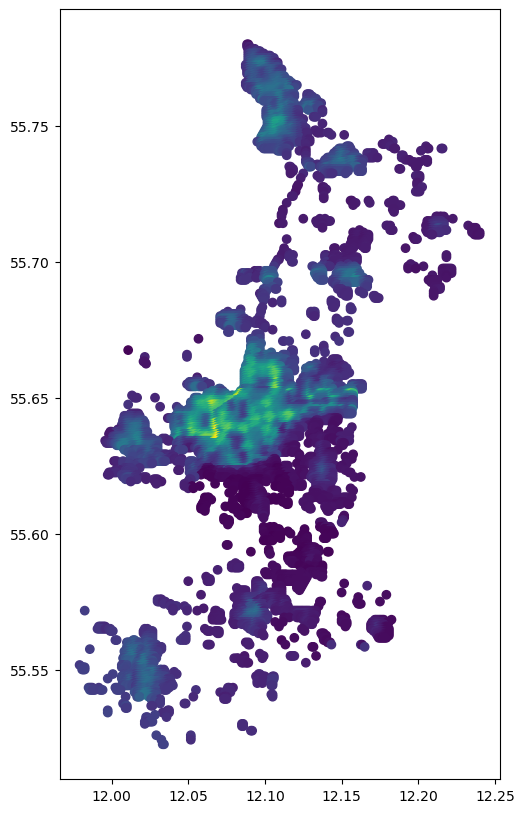

In [200]:
exp_pop.gdf.plot(column="value", figsize=(10, 10))

<Axes: >

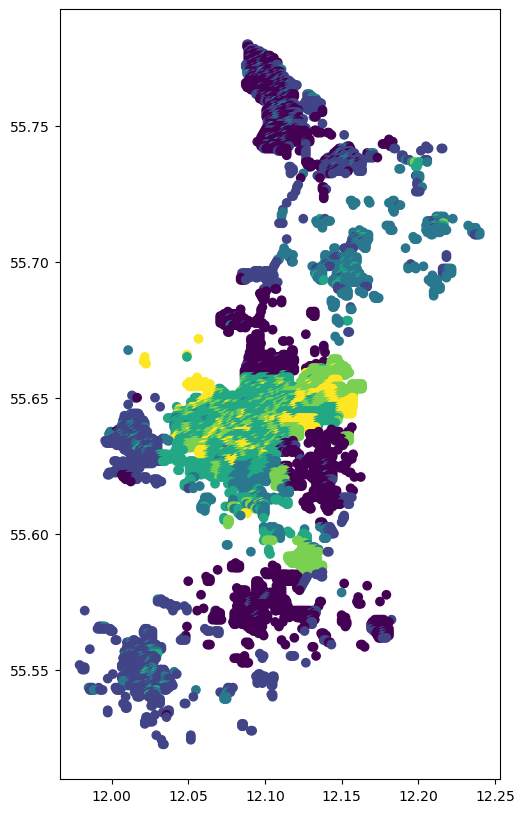

In [201]:
exp_pop.gdf.plot(column="group_id", figsize=(10, 10))

### Relocate pop layer too

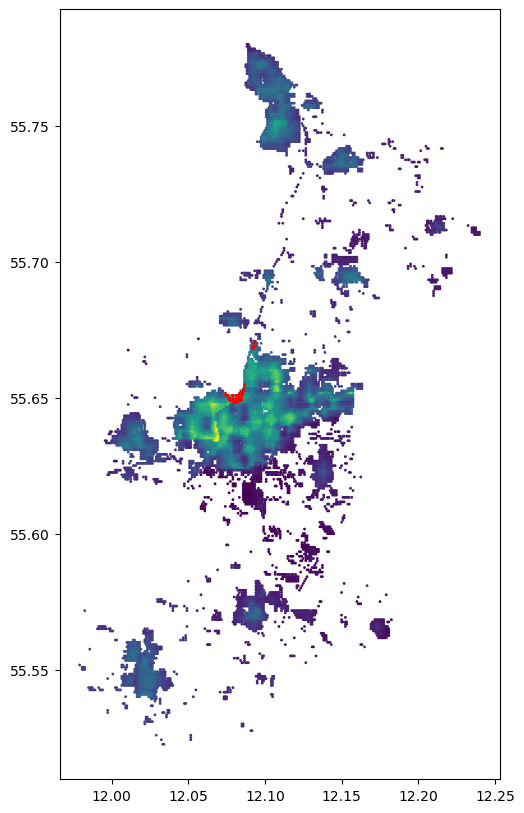

In [188]:
relocation = gpd.read_file("./DATA/MCA/coastal_retreat_zone.geojson")
exp_gdf = exp_pop.gdf.copy()
to_remove = exp_gdf.sjoin(relocation, how="inner", predicate="within")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
exp_gdf.plot(column="value", ax=ax, markersize=1.0)
exp_gdf.loc[to_remove.index].plot(color="red", ax=ax, markersize=1.0)
exp_gdf = exp_gdf.drop(to_remove.index)
exp_gdf["group_id"] = exp_pop.gdf.loc[exp_gdf.index, "group_id"]
exp_pop_relocate = Exposures(exp_gdf)

In [190]:
exp_pop_relocate.write_hdf5(
    "./DATA/MCA/built_inputs/exposure_people_relocated_with_SVI.hdf5"
)

### Hazard layer

I struggled a bit with this (projection/resolution/mapping), and in the end managed to make it work with QGIS (and I'm not so sure why it work tbh), given the time I will send you the files which work and understand what went wrong here

In [ ]:
hazards_basefiles = {
    "1_5m": (data_path / "WD_15_nobarrier.tif", 5),
    "1_5m_eastbarrier": (data_path / "WD_15_eastbarrier.tif", 5),
    "1_5m_allbarriers": (data_path / "WD_15_allbarriers.tif", 5),
    "2_38m": (data_path / "WD_238_nobarrier.tif", 30),
    "2_38m_eastbarrier": (data_path / "WD_238_eastbarrier.tif", 30),
    "2_38m_allbarriers": (data_path / "WD_238_allbarriers.tif", 30),
    "3m": (data_path / "WD_300_nobarrier.tif", 100),
    "3m_eastbarrier": (data_path / "WD_300_eastbarrier.tif", 100),
    "3m_allbarriers": (data_path / "WD_300_allbarriers.tif", 100),
}

#### Attempts with xarray?

In [ ]:
import xarray as xr
import rioxarray

In [48]:
time_coords = pd.to_datetime(["2020-01-01", "2021-01-01"])

In [ ]:
haz_xr = xr.open_mfdataset(
    [hazards_basefiles["2_38m"][0], hazards_basefiles["3m"][0]],
    combine="nested",
    concat_dim="time",
    engine="rasterio",
)
haz_xr["time"] = time_coords

In [65]:
haz_xr

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 2, band: 1, y: 12153, x: 14219)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 114kB 1.34e+06 1.34e+06 ... 1.354e+06 1.354e+06
  * y            (y) float64 97kB 7.494e+06 7.494e+06 ... 7.482e+06 7.482e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 16B 2020-01-01 2021-01-01
Data variables:
    band_data    (time, band, y, x) float32 1GB dask.array<chunksize=(1, 1, 512, 512), meta=np.ndarray>

In [68]:
haz_xr = rasterio.open(hazards_basefiles["2_38m"][0])

In [73]:
print(haz_xr.crs)

EPSG:3857


In [50]:
haz_xr_coarsened = haz_xr.coarsen(x=10, y=10, boundary="trim").mean()

In [51]:
haz_xr_coarsened = haz_xr_coarsened.to_dataset("band")

AttributeError: 'Dataset' object has no attribute 'to_dataset'

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 2, y: 1215, x: 1421)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 11kB 1.34e+06 1.34e+06 ... 1.354e+06 1.354e+06
  * y            (y) float64 10kB 7.494e+06 7.494e+06 ... 7.482e+06 7.482e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 16B 2020-01-01 2021-01-01
Data variables:
    band_data    (time, y, x) float32 14MB dask.array<chunksize=(1, 51, 51), meta=np.ndarray>

In [74]:
test = Hazard.from_xarray_raster(
    haz_xr_coarsened.sel(band=1),
    hazard_type="CF",
    intensity_unit="m",
    coordinate_vars=dict(event="time", longitude="x", latitude="y"),
    intensity="band_data",
    crs="3857",
)

In [79]:
test = test.select_tight()

AttributeError: 'NoneType' object has no attribute 'select_tight'

In [ ]:
test

#### Attempts with rasterio

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = "EPSG:25832"  # metric CRS for denmark


def to_meters_raster(hazard_raster_full_path):
    print(
        f"reprojecting {hazard_raster_full_path} to {dst_crs}, saving to {hazard_raster_full_path.with_name(hazard_raster_full_path.stem+'_EPSG25832'+hazard_raster_full_path.suffix)}"
    )
    with rasterio.open(hazard_raster_full_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )
        with rasterio.open(
            hazard_raster_full_path.with_name(
                hazard_raster_full_path.stem
                + "_EPSG25832"
                + hazard_raster_full_path.suffix
            ),
            "w",
            **kwargs,
        ) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )

In [12]:
def coarsen_reproj_raster(hazard_raster_full_path, coarsening_factor, dst_crs):
    print(
        f"coarsening {hazard_raster_full_path} to {coarsening_factor}, saving to {hazard_raster_full_path.with_name(hazard_raster_full_path.stem+'_coarsened'+hazard_raster_full_path.suffix)}"
    )
    with rasterio.open(hazard_raster_full_path) as src:
        # Calculate the new transform and dimensions based on the target CRS
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        # Apply the coarsening factor to the new dimensions and transform
        new_width = int(width / coarsening_factor)
        new_height = int(height / coarsening_factor)
        new_transform = transform * transform.scale(
            src.width / new_width, src.height / new_height
        )
        # Update metadata for the new raster
        profile = src.profile.copy()
        profile.update(
            {
                "crs": dst_crs,
                "transform": new_transform,
                "width": new_width,
                "height": new_height,
                "nodata": src.nodata,
                "dtype": src.profile["dtype"],
            }
        )

        # Prepare an empty array for the destination data
        destination = np.zeros((new_height, new_width), dtype=profile["dtype"])

        # Reproject and resample the data
        reproject(
            source=rasterio.band(src, 1),
            destination=destination,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=new_transform,
            dst_crs=dst_crs,
            src_nodata=src.nodata,
            dst_nodata=0,
            resampling=Resampling.nearest,  # Use a suitable resampling method
        )
        output_path = hazard_raster_full_path.with_name(
            hazard_raster_full_path.stem
            + f"_coarsened_{dst_crs[-4:]}"
            + hazard_raster_full_path.suffix
        )
        # Write the reprojected and coarsened raster to a new file
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(destination, 1)

    print(f"Raster successfully reprojected and coarsened to {output_path}")

In [237]:
def create_hazard_obj(hazard_raster_full_path, exp, exp_polygons, name, output, rp):
    # ---- Step 1: Define Parameters ----
    # Define the file path and parameters
    hazard_type = "CF"  # Type of the hazard, ideally a two-letter identifier
    intensity_unit = "m"  # Unit of intensity, just for plots
    n_ev = 1  # Number of events
    frequency = np.ones(n_ev) / rp  # Arbitrary frequency of the event
    event_id = np.arange(1, dtype=int)  # Event ID (e.g., 1 event in this case)
    print(f"Generating hazard for buildings")
    if not hazard_raster_full_path.with_name(
        hazard_raster_full_path.stem + "_EPSG25832" + hazard_raster_full_path.suffix
    ).exists():
        to_meters_raster(hazard_raster_full_path)

    hazard_raster_full_path = hazard_raster_full_path.with_name(
        hazard_raster_full_path.stem + "_EPSG25832" + hazard_raster_full_path.suffix
    )
    # Define the buffer ...
    buffer_distance = 20  # Buffer distance for each building (in meters)

    # ---- Step 2: Copy Exposure Data and Prepare for Processing ----
    haz_dummy_gdf = exp.gdf[["geometry"]].copy()
    haz_dummy_gdf_poly = exp_polygons[["geometry"]].copy()
    # ---- Step 3: Open the Raster File and Get CRS ----
    with rasterio.open(hazard_raster_full_path) as src:
        raster_crs = src.crs  # Assume the raster CRS is not geographic (e.g., UTM)
        raster_bounds = src.bounds
        raster_nodata = src.nodata

    # ---- Step 4: Apply Buffer to Building Geometries ----
    # If the GeoDataFrame CRS does not match the raster CRS, reproject it
    if haz_dummy_gdf.crs != raster_crs:
        haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
        haz_dummy_gdf_poly = haz_dummy_gdf_poly.to_crs(raster_crs)
        print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")

    haz_dummy_gdf["geometry_polygon"] = haz_dummy_gdf_poly["geometry"]
    haz_dummy_gdf["geometry_polygon_buffered"] = haz_dummy_gdf_poly["geometry"].buffer(
        buffer_distance
    )
    # Convert raster bounds to a Shapely Polygon for intersection checking
    raster_bounds_polygon = box(
        raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top
    )

    # ---- Step 5: Define Function to Calculate Mean Water Depth, Excluding Building Area ----
    def calculate_mean_water_excluding_building(
        geom, building_geom, src, raster_nodata, raster_bounds_polygon
    ):
        """
        This function calculates the mean water depth (intensity) within the buffered area around a building,
        excluding water pixels that fall within the building polygon itself.

        It masks the raster (water depth) data to the area covered by the building's buffer, subtracts the building geometry,
        and calculates the average water depth over the remaining valid pixels.

        Parameters:
        - geom: The geometry of the buffered building (Polygon).
        - building_geom: The original building geometry to exclude water pixels inside.
        - src: The raster dataset (opened .tif file) containing water depth values.
        - raster_nodata: The value that represents missing or "no data" in the raster file.
        - raster_bounds_polygon: The bounding box of the raster file as a Shapely Polygon.

        Returns:
        - The mean water depth within the buffer area of the building, excluding the building polygon, or 0 if no valid water pixels are found.
        """
        # Check if the buffered building geometry intersects the raster area
        if geom.intersects(raster_bounds_polygon):
            # Create a new geometry by subtracting the building geometry from the buffered area
            buffer_minus_building = geom.difference(building_geom)

            if buffer_minus_building.is_empty:
                return 0  # If there's no area left after subtracting the building, return 0

            # Convert the buffered-minus-building geometry to GeoJSON for raster masking
            geom_geojson = [mapping(buffer_minus_building)]

            # Mask the raster using the adjusted geometry (buffer minus building), and extract water depth values
            out_image, _ = mask(src, geom_geojson, crop=True, nodata=raster_nodata)
            water_pixels = out_image.flatten()
            water_pixels[water_pixels == raster_nodata] = 0
            # Filter out invalid values (nodata and handle NaNs), but include zero water pixels
            valid_water_pixels = water_pixels  # [(water_pixels != raster_nodata)]

            # Return the mean water depth if valid water pixels exist, otherwise return 0
            if valid_water_pixels.size == 0 or np.isnan(valid_water_pixels).all():
                return 0  # Return 0 if all valid water pixels are NaN or if there are no valid water pixels
            else:
                return np.nanmean(valid_water_pixels)

        else:
            # If the building doesn't intersect with the raster, return 0
            return 0

    # ---- Step 6: Apply the Mean Water Calculation to Each Buffered Building Geometry ----
    with rasterio.open(hazard_raster_full_path) as src:
        # Apply the mean water calculation function to each buffered building geometry
        haz_dummy_gdf["mean_water"] = haz_dummy_gdf.apply(
            lambda row: calculate_mean_water_excluding_building(
                row["geometry_polygon_buffered"],
                row["geometry_polygon"],
                src,
                raster_nodata,
                raster_bounds_polygon,
            ),
            axis=1,
        )

    # ---- Step 7: Reproject Back to Geographic CRS (EPSG:4326) ----
    haz_dummy_gdf = haz_dummy_gdf.to_crs(4326)
    # ---- Step 8: Create the Hazard Object for CLIMADA ----
    haz_dummy = Hazard(
        haz_type=hazard_type,
        intensity=csr_matrix([haz_dummy_gdf["mean_water"]]),
        centroids=Centroids(
            lat=haz_dummy_gdf.geometry.centroid.y,
            lon=haz_dummy_gdf.geometry.centroid.x,
            crs="EPSG:4326",
        ),
        units=intensity_unit,
        event_id=event_id,
        event_name=[name],
        date=[1],
        frequency=frequency,
    )
    haz_dummy.write_hdf5(output / (name + "_buildings.hdf5"))
    return haz_dummy

In [40]:
def create_hazard_pop(hazard_raster_full_path, exp, name, output, rp, radius_meter=50):
    def get_average_value_in_radius(row, raster_file, radius, raster_bounds_polygon):
        """
        Calculates the average raster value within a buffer around a point.
        """
        # Create a buffer around the point geometry
        buffer_geom = row.geometry.buffer(radius)
        if buffer_geom.intersects(raster_bounds_polygon):

            with rasterio.open(raster_file) as src:
                # Mask the raster with the buffer geometry
                out_image, out_transform = rasterio.mask.mask(
                    src, [buffer_geom], crop=True
                )

                # Flatten the array and remove NoData values
                # The NoData value can be retrieved from the raster metadata
                nodata = src.nodata
                valid_values = out_image.flatten()
                if nodata is not None:
                    valid_values = valid_values[valid_values != nodata]

                # Calculate the average and return it
                if valid_values.size > 0:
                    return np.mean(valid_values)
                else:
                    return None  # Return None if no valid data is found

    # ---- Step 1: Define Parameters ----
    # Define the file path and parameters
    hazard_type = "CF"  # Type of the hazard, ideally a two-letter identifier
    intensity_unit = "m"  # Unit of intensity, just for plots
    n_ev = 1  # Number of events
    frequency = np.ones(n_ev) / rp  # Arbitrary frequency of the event
    event_id = np.arange(1, dtype=int)  # Event ID (e.g., 1 event in this case)

    print(f"Reading {hazard_raster_full_path} for population hazard.")
    if not hazard_raster_full_path.with_name(
        hazard_raster_full_path.stem + "_EPSG25832" + hazard_raster_full_path.suffix
    ).exists():
        to_meters_raster(hazard_raster_full_path)

    hazard_raster_full_path = hazard_raster_full_path.with_name(
        hazard_raster_full_path.stem + "_EPSG25832" + hazard_raster_full_path.suffix
    )

    # ---- Step 2: Copy Exposure Data and Prepare for Processing ----
    haz_dummy_gdf = exp.gdf[["geometry"]].copy()
    # ---- Step 3: Open the Raster File and Get CRS ----
    with rasterio.open(hazard_raster_full_path) as src:
        raster_crs = src.crs  # Assume the raster CRS is not geographic (e.g., UTM)
        raster_bounds = src.bounds
        raster_nodata = src.nodata

    raster_bounds_polygon = box(
        raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top
    )
    # ---- Step 4: Apply Buffer to Building Geometries ----
    # If the GeoDataFrame CRS does not match the raster CRS, reproject it
    if haz_dummy_gdf.crs != raster_crs:
        haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
        print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")

    # Apply the function to each row of the GeoDataFrame
    haz_dummy_gdf["mean_water"] = haz_dummy_gdf.apply(
        lambda row: get_average_value_in_radius(
            row, hazard_raster_full_path, radius_meter, raster_bounds_polygon
        ),
        axis=1,
    )

    haz_dummy_gdf = haz_dummy_gdf.to_crs(4326)
    # ---- Step 8: Create the Hazard Object for CLIMADA ----
    haz_dummy = Hazard(
        haz_type=hazard_type,
        intensity=csr_matrix([haz_dummy_gdf["mean_water"]]),
        centroids=Centroids(
            lat=haz_dummy_gdf.geometry.y,
            lon=haz_dummy_gdf.geometry.x,
            crs="EPSG:4326",
        ),
        units=intensity_unit,
        event_id=event_id,
        event_name=[name],
        date=[1],
        frequency=frequency,
    )
    haz_dummy.write_hdf5(output / (name + "_pop.hdf5"))
    return haz_dummy

In [238]:
exp_build_base = Exposures.from_hdf5(
    "./DATA/MCA/built_inputs/exposure_base_with_SVI.hdf5"
)
exp_polygons_base = gpd.read_file(data_path / "osm_buildings_roskilde_120705.geojson")
for haz, (path, rp) in hazards_basefiles.items():
    create_hazard_obj(
        path,
        exp_base,
        exp_polygons_base,
        haz,
        output=(data_path / "built_inputs"),
        rp=rp,
    )

Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


Generating hazard for buildings
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832


/tmp/ipykernel_2907640/2850890208.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat=haz_dummy_gdf.geometry.centroid.y,
/tmp/ipykernel_2907640/2850890208.py:117: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon=haz_dummy_gdf.geometry.centroid.x,


In [41]:
exp_pop = Exposures.from_hdf5("./DATA/MCA/built_inputs/exposure_people_with_SVI.hdf5")
for haz, (path, rp) in hazards_basefiles.items():
    create_hazard_pop(path, exp_pop, haz, output=(data_path / "built_inputs"), rp=rp)

Reading DATA/MCA/WD_15_nobarrier.tif for population hazard.
BoundingBox(left=690766.8916898116, bottom=6167115.8352188, right=699108.1297458415, top=6174327.877961059)
Reprojected GeoDataFrame to match the raster CRS: EPSG:25832
                 minx          miny           maxx          maxy
480     693670.879057  6.185912e+06  693670.879057  6.185912e+06
481     693723.119176  6.185915e+06  693723.119176  6.185915e+06
818     693675.014496  6.185820e+06  693675.014496  6.185820e+06
819     693727.255732  6.185822e+06  693727.255732  6.185822e+06
820     693779.496953  6.185824e+06  693779.496953  6.185824e+06
...               ...           ...            ...           ...
103864  692620.797315  6.157446e+06  692620.797315  6.157446e+06
104179  691415.455265  6.157300e+06  691415.455265  6.157300e+06
104202  692624.871082  6.157353e+06  692624.871082  6.157353e+06
104856  691476.137143  6.157117e+06  691476.137143  6.157117e+06
104857  691528.722813  6.157119e+06  691528.722813  6.15

### Vulnerability (impact function) input

This one is quite straightforward, it could probably easily be changed using sliders in the front-end.

We define one as a basis, and one with a threshold corresponding to new building codes. (I can write a helper function for that if needed)

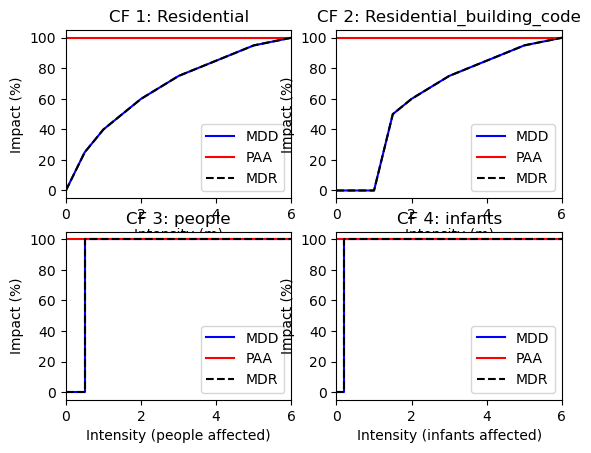

In [191]:
import numpy as np
from climada.entity import ImpactFunc, ImpactFuncSet

# Define the impact function parameters
haz_type = "CF"  # Type of the hazard, ideally a two-letter identifier
impf_id1 = 1  # Identifier of the event
impf_id2 = 2  # Identifier of the event
impf_id3 = 3  # Identifier of the event
impf_id4 = 4  # Identifier of the event
intensity = np.array(
    [0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6]
)  # Intensity values from the plot
intensity_people = np.array([0, 0.20, 0.5, 1, 6])  # Intensity values from the plot
mdd = np.array([0, 25, 40, 50, 60, 75, 85, 95, 100]) * (1 / 100)
mdd_building_codes = np.array([0, 0, 0, 50, 60, 75, 85, 95, 100]) * (1 / 100)
paa = np.ones(len(intensity))
intensity_unit = "m"  # Unit of intensity, just for plots
name = "Residential"  # Name of the impact function
name2 = "Residential_building_code"  # Name of the impact function
name3 = "people"
name4 = "infants"


# Create an ImpactFunc object
impf1 = ImpactFunc(
    haz_type=haz_type,  # Type of the hazard
    id=impf_id1,  # Identifier of the event
    intensity=intensity,  # Intensity values
    mdd=mdd,  # Mean damage distribution
    paa=paa,  # Probability of being in each damage state
    intensity_unit=intensity_unit,  # Unit of intensity
    name=name,  # Name of the impact function
)

impf1_building_code = ImpactFunc(
    haz_type=haz_type,  # Type of the hazard
    id=impf_id2,  # Identifier of the event
    intensity=intensity,  # Intensity values
    mdd=mdd_building_codes,  # Mean damage distribution
    paa=paa,  # Probability of being in each damage state
    intensity_unit=intensity_unit,  # Unit of intensity
    name=name2,  # Name of the impact function
)

impf_people = ImpactFunc.from_step_impf(
    [0.0, 0.5, 6],
    haz_type=haz_type,
    impf_id=impf_id3,
    intensity_unit="people affected",  # Unit of intensity
    name=name3,  # Name of the impact function
)

impf_infants = ImpactFunc.from_step_impf(
    [0.0, 0.2, 6],
    haz_type=haz_type,
    impf_id=impf_id4,
    intensity_unit="infants affected",  # Unit of intensity
    name=name4,  # Name of the impact function
)


# Define the impact function set
impfset = ImpactFuncSet([impf1, impf1_building_code, impf_people, impf_infants])

#  Plot the impact functions
impfset.plot()

# Check the impact function set
impfset.check()

In [58]:
# Save the ImpactFuncSet to a file
save_impact_funcs_to_json(
    [impf1, impf1_building_code, impf_people, impf_infants],
    data_path / "built_inputs/impact_functions.json",
)

# Load the ImpactFuncSet back from the file
loaded_impact_funcs = load_impact_funcs_from_json(
    data_path / "built_inputs/impact_functions.json"
)

if loaded_impact_funcs:
    print("\nVerification:")
    print(f"Loaded object 1 name: {loaded_impact_funcs[0].name}")
    print(f"Loaded object 1 mdd (first 5 values): {loaded_impact_funcs[0].mdd[:5]}")
    print(f"Loaded object 2 name: {loaded_impact_funcs[1].name}")
    print(f"Loaded object 2 mdd (first 5 values): {loaded_impact_funcs[1].mdd[:5]}")

NameError: name 'impf1' is not defined

## Loading built data for appraisal

In [ ]:
import numpy as np
from climada.entity import ImpactFunc, ImpactFuncSet

In [192]:
haz_type = "CF"

In [193]:
exp_build_base = Exposures.from_hdf5(
    "./DATA/MCA/built_inputs/exposure_base_with_SVI.hdf5"
)
exp_build_relocate = Exposures.from_hdf5(
    "./DATA/MCA/built_inputs/exposure_relocate_with_SVI.hdf5"
)
exp_pop = Exposures.from_hdf5("./DATA/MCA/built_inputs/exposure_people_with_SVI.hdf5")
exp_pop_relocate = Exposures.from_hdf5(
    "./DATA/MCA/built_inputs/exposure_people_relocated_with_SVI.hdf5"
)

In [194]:
# Load the ImpactFuncSet back from the file
loaded_impact_funcs = load_impact_funcs_from_json(
    data_path / "built_inputs/impact_functions.json"
)

Successfully loaded 4 impact functions from 'DATA/MCA/built_inputs/impact_functions.json'


In [195]:
impfset = ImpactFuncSet(loaded_impact_funcs)

array([[<Axes: title={'center': 'CF 1: Residential'}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'CF 2: Residential_building_code'}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'CF 3: people'}, xlabel='Intensity (people affected)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'CF 4: infants'}, xlabel='Intensity (infants affected)', ylabel='Impact (%)'>]],
      dtype=object)

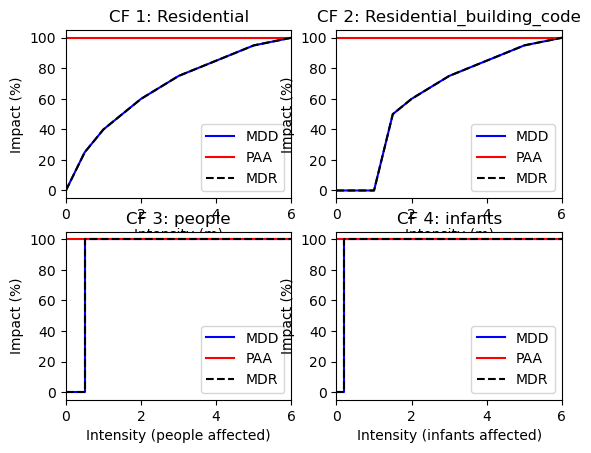

In [196]:
impfset.plot()

In [197]:
exp_build_base.gdf[f"impf_{haz_type}"] = 1
exp_build_relocate.gdf[f"impf_{haz_type}"] = 1
exp_pop.gdf[f"impf_{haz_type}"] = 3
exp_pop_relocate.gdf[f"impf_{haz_type}"] = 3

In [8]:
data_path = Path("/home/sjuhel/Repos/interoperability_sandbox/CLIMADA/DATA/MCA")

In [9]:
hazards = {
    "building": Hazard.concat(
        [
            Hazard.from_hdf5(data_path / "built_inputs" / "1_5m_buildings.hdf5"),
            Hazard.from_hdf5(data_path / "built_inputs" / "2_38m_buildings.hdf5"),
            Hazard.from_hdf5(data_path / "built_inputs" / "3m_buildings.hdf5"),
        ]
    ),
    "pop": Hazard.concat(
        [
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_15_nobarrier.tif", haz_type=hazard_type
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_238_nobarrier.tif",
                haz_type=hazard_type,
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_300_nobarrier.tif",
                haz_type=hazard_type,
            ),
        ]
    ),
}

hazards_barrier = {
    "building": Hazard.concat(
        [
            Hazard.from_hdf5(
                data_path / "built_inputs" / "1_5m_eastbarrier_buildings.hdf5"
            ),
            Hazard.from_hdf5(
                data_path / "built_inputs" / "2_38m_eastbarrier_buildings.hdf5"
            ),
            Hazard.from_hdf5(
                data_path / "built_inputs" / "3m_eastbarrier_buildings.hdf5"
            ),
        ]
    ),
    "pop": Hazard.concat(
        [
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_15_eastbarrier.tif",
                haz_type=hazard_type,
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_238_eastbarrier.tif",
                haz_type=hazard_type,
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_300_eastbarrier.tif",
                haz_type=hazard_type,
            ),
        ]
    ),
}

hazards_allbarriers = {
    "building": Hazard.concat(
        [
            Hazard.from_hdf5(
                data_path / "built_inputs" / "1_5m_allbarriers_buildings.hdf5"
            ),
            Hazard.from_hdf5(
                data_path / "built_inputs" / "2_38m_allbarriers_buildings.hdf5"
            ),
            Hazard.from_hdf5(
                data_path / "built_inputs" / "3m_allbarriers_buildings.hdf5"
            ),
        ]
    ),
    "pop": Hazard.concat(
        [
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_15_allbarriers.tif",
                haz_type=hazard_type,
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_238_allbarriers.tif",
                haz_type=hazard_type,
            ),
            Hazard.from_raster(
                data_path / "pop_haz" / "1testWD_300_allbarriers.tif",
                haz_type=hazard_type,
            ),
        ]
    ),
}

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/sjuhel/Repos/interoperability_sandbox/CLIMADA/DATA/MCA/built_inputs/1_5m_buildings.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [199]:
for haz in hazards.values():
    haz.intensity.data = np.nan_to_num(haz.intensity.data)
    haz.intensity.eliminate_zeros()

for haz in hazards_allbarriers.values():
    haz.intensity.data = np.nan_to_num(haz.intensity.data)
    haz.intensity.eliminate_zeros()

for haz in hazards_barrier.values():
    haz.intensity.data = np.nan_to_num(haz.intensity.data)
    haz.intensity.eliminate_zeros()

## Computation and appraisal

The new modules we've developed far are made to compare between multiple points in time, and look at the evolution in between.

In this example it doesn't really make sense, but at the moment we still need to define a future point for it to work, so we'll define a dummy one which we will not use.

I realize this is slightly anoying because it requires selection of the results all the time, so I'll try to find a way to overcome that.

In [200]:
from climada.trajectories.snapshot import Snapshot
from climada.engine.option_appraisal.appraiser import MeasuresAppraiser

In [201]:
ref_year = 2025
future_year = 2027

In [202]:
exp_build_base.assign_centroids(hazards["building"])
snap_base = Snapshot(exp_build_base, hazards["building"], impfset, date=ref_year)
snap_future = Snapshot(exp_build_base, hazards["building"], impfset, date=future_year)

In [203]:
exp_pop.assign_centroids(hazards["pop"])
snap_pop = Snapshot(exp_pop, hazards["pop"], impfset, date=ref_year)
snap_pop_future = Snapshot(exp_pop, hazards["pop"], impfset, date=future_year)

In [204]:
from climada.entity.measures.cost_income import CostIncome
from climada.entity import Measure, MeasureSet
from climada.entity.measures.base import (
    helper_hazard,
    helper_exposure,
    helper_impfset,
    impact_intensity_rp_cutoff,
)

### Defining measures

Defining measures is defining their effect on either hazard, exposure or vulnerability (or a combination)

For instance we can define these functions:

In [205]:
# These could be lambda functions directly,
# but it showcase how more complexe measure
# could be designed
def haz_apply_barrier(haz, haz_barrier):
    return haz_barrier


def exp_apply_relocate(exp):
    if exp.value_unit == "USD":
        return exp_build_relocate
    if exp.value_unit == "people":
        return exp_pop_relocate
    else:
        raise ValueError("no matching relocate exposure")


# Changing the impact function is actually changing the assignement in the exposure
def change_impf(exp, new_id):
    exp = exp.copy()
    exp.gdf["impf_CF"] = new_id
    return exp


def early_warning(exp, share_protected):
    exp = exp.copy()
    exp.gdf["value"] *= 1 - share_protected
    return exp

Then we can define measures objects:

In [206]:
exp_pop.gdf["value"].sum()

82049.91

In [207]:
exp_pop_relocate.gdf["value"].sum()

81279.88

In [208]:
per_meter_barrier_cost = 16 * 1e3
east_barrier_cost = per_meter_barrier_cost * 1800
west_barrier_cost = per_meter_barrier_cost * 900
north_barrier_cost = per_meter_barrier_cost * 1300
all_barriers_cost = east_barrier_cost + west_barrier_cost + north_barrier_cost

measure_eastbarrier_b = Measure(
    name="East Barrier",  # Name identifying the measure
    haz_type="CF",  # Currently not actually used (only an identifier)
    hazard_change=lambda x, _: haz_apply_barrier(
        x, hazards_barrier["building"]
    ),  # The effect on hazard
    cost_income=CostIncome(  # A cost_income needs to be defined for the measure
        # Most of its attributes are only important when comparing present / future, evolution
        # Init cost should be included in our case
        mkt_price_year=2025,
        init_cost=east_barrier_cost * (-1),
        # periodic_cost=1e3*800,
        freq="AS-JAN",  # This avoids a warning
    ),
)

measure_allbarriers_b = Measure(
    name="All barriers",  # Name identifying the measure
    haz_type="CF",  # Currently not actually used (only an identifier)
    hazard_change=lambda x, _: haz_apply_barrier(
        x, hazards_allbarriers["building"]
    ),  # The effect on hazard
    cost_income=CostIncome(  # A cost_income needs to be defined for the measure
        # Most of its attributes are only important when comparing present / future, evolution
        # Init cost should be included in our case
        mkt_price_year=2025,
        init_cost=-all_barriers_cost,
        # periodic_cost=1e3*800,
        freq="AS-JAN",  # This avoids a warning
    ),
)

measure_eastbarrier_p = Measure(
    name="East Barrier",  # Name identifying the measure
    haz_type="CF",  # Currently not actually used (only an identifier)
    hazard_change=lambda x, _: haz_apply_barrier(
        x, hazards_barrier["pop"]
    ),  # The effect on hazard
    cost_income=CostIncome(  # A cost_income needs to be defined for the measure
        # Most of its attributes are only important when comparing present / future, evolution
        # Init cost should be included in our case
        mkt_price_year=2025,
        init_cost=-east_barrier_cost,
        # periodic_cost=1e3*800,
        freq="AS-JAN",  # This avoids a warning
    ),
)

measure_allbarriers_p = Measure(
    name="All barriers",  # Name identifying the measure
    haz_type="CF",  # Currently not actually used (only an identifier)
    hazard_change=lambda x, _: haz_apply_barrier(
        x, hazards_allbarriers["pop"]
    ),  # The effect on hazard
    cost_income=CostIncome(  # A cost_income needs to be defined for the measure
        # Most of its attributes are only important when comparing present / future, evolution
        # Init cost should be included in our case
        mkt_price_year=2025,
        init_cost=-all_barriers_cost,
        # periodic_cost=1e3*800,
        freq="AS-JAN",  # This avoids a warning
    ),
)


measure_relocate = Measure(
    name="Relocate",
    haz_type="CF",
    exposures_change=lambda x, _: exp_apply_relocate(x),
    cost_income=CostIncome(mkt_price_year=2025, init_cost=-8 * 1e9, freq="AS-JAN"),
)

measure_building_code = Measure(
    haz_type="CF",
    name="Building code",
    exposures_change=helper_exposure(
        reassign_impf_id=2, haz_type="CF"
    ),  # This is an helper we developed that basically does the same as `change_impf` above. We can (and plan) to design more of those, depending on needs
    cost_income=CostIncome(mkt_price_year=2025, init_cost=-50_000_000, freq="AS-JAN"),
)

share_protected = 0.1

measure_warning = Measure(
    name="Early warning",  # Name identifying the measure
    haz_type="CF",  # Currently not actually used (only an identifier)
    exposures_change=lambda x, _: early_warning(
        x, share_protected=share_protected
    ),  # This is the default value if not specified, meaning "no change"
    cost_income=CostIncome(  # A cost_income needs to be defined for the measure
        # Most of its attributes are only important when comparing present / future, evolution
        # Init cost should be included in our case
        mkt_price_year=2025,
        init_cost=-200_000,
        # periodic_cost=1e3*800,
        freq="AS-JAN",  # This avoids a warning
    ),
)

Below is the main object for the options appraisal, all the measures in `measure_set` are compared.

Most computations are JIT and some of the "heavy ones" are cached. Memory and computation requirements should remain very reasonable (especially without the time dimension and single event hazards)

In [209]:
appraiser_building = MeasuresAppraiser(
    [
        snap_base,
        snap_future,
    ],
    measure_set=MeasureSet(
        measures=[
            measure_eastbarrier_b,
            measure_allbarriers_b,
            measure_relocate,
            measure_building_code,
            measure_warning,
        ]
    ),
)
appraiser_building.default_rp = [5, 30, 100]

In [210]:
appraiser_pop = MeasuresAppraiser(
    [
        snap_pop,
        snap_pop_future,
    ],
    measure_set=MeasureSet(
        measures=[
            measure_eastbarrier_p,
            measure_allbarriers_p,
            measure_relocate,
            measure_warning,
        ]
    ),
)
appraiser_pop.default_rp = [5, 30, 100]

`per_date_CB()` computes and returns all risk metrics in a tidy dataframe

In [211]:
results_building = appraiser_building.per_date_CB()

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 529.02it/s]


In [212]:
results_pop = appraiser_pop.per_date_CB()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 523.51it/s]


In [213]:
results_building = results_building.loc[results_building["date"].isin(["2025-01-01"])]

In [214]:
results_building

,date,group,measure,metric,risk,reference risk,averted risk,measure net cost,benefit minus cost,cumulated measure cost,cumulated measure benefit,cost/benefit ratio
0,2025-01-01,All,no_measure,aai,4.828861e+05,4.828861e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2025-01-01,All,East Barrier,aai,4.218167e+05,4.828861e+05,6.106936e+04,2.880000e+07,-2.873893e+07,2.880000e+07,6.106936e+04,4.715949e+02
1,2025-01-01,All,All barriers,aai,3.712084e+05,4.828861e+05,1.116777e+05,6.400000e+07,-6.388832e+07,6.400000e+07,1.116777e+05,5.730775e+02
2,2025-01-01,All,Relocate,aai,1.240310e+05,4.828861e+05,3.588551e+05,8.000000e+09,-7.999641e+09,8.000000e+09,3.588551e+05,2.229312e+04
3,2025-01-01,All,Building code,aai,7.673459e+03,4.828861e+05,4.752126e+05,5.000000e+07,-4.952479e+07,5.000000e+07,4.752126e+05,1.052161e+02
4,2025-01-01,All,Early warning,aai,4.345975e+05,4.828861e+05,4.828861e+04,2.000000e+05,-1.517114e+05,2.000000e+05,4.828861e+04,4.141763e+00
0,2025-01-01,All,no_measure,rp_100,1.048085e+07,1.048085e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2025-01-01,All,no_measure,rp_30,5.926970e+06,5.926970e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2025-01-01,All,no_measure,rp_5,1.188825e+06,1.188825e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
0,2025-01-01,All,East Barrier,rp_100,8.327529e+06,1.048085e+07,2.153317e+06,2.880000e+07,-2.664668e+07,2.880000e+07,2.153317e+06,1.337471e+01


In [215]:
results_pop = results_pop.loc[results_pop["date"].isin(["2025-01-01"])]

In [216]:
results_pop

,date,group,measure,metric,risk,reference risk,averted risk,measure net cost,benefit minus cost,cumulated measure cost,cumulated measure benefit,cost/benefit ratio
0,2025-01-01,All,no_measure,aai,773.589831,773.589831,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN
0,2025-01-01,All,East Barrier,aai,575.950063,773.589831,197.639768,2.880000e+07,-2.879980e+07,2.880000e+07,197.639768,1.457197e+05
1,2025-01-01,All,All barriers,aai,484.062539,773.589831,289.527292,6.400000e+07,-6.399971e+07,6.400000e+07,289.527292,2.210500e+05
2,2025-01-01,All,Relocate,aai,268.667219,773.589831,504.922612,8.000000e+09,-7.999999e+09,8.000000e+09,504.922612,1.584401e+07
3,2025-01-01,All,Early warning,aai,696.230835,773.589831,77.358996,2.000000e+05,-1.999226e+05,2.000000e+05,77.358996,2.585349e+03
0,2025-01-01,All,no_measure,rp_100,508.647489,508.647489,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN
0,2025-01-01,All,no_measure,rp_30,508.647489,508.647489,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN
0,2025-01-01,All,no_measure,rp_5,508.647489,508.647489,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN
0,2025-01-01,All,East Barrier,rp_100,382.413022,508.647489,126.234467,2.880000e+07,-2.879987e+07,2.880000e+07,126.234467,2.281469e+05
1,2025-01-01,All,East Barrier,rp_30,382.413022,508.647489,126.234467,2.880000e+07,-2.879987e+07,2.880000e+07,126.234467,2.281469e+05


In [217]:
results_building["risk_unit"] = "euros"
results_pop["risk_unit"] = "people"

In [218]:
results = pd.concat([results_building, results_pop])

In [219]:
results["group"] = results["group"].astype(str)

In [221]:
tmp = results.loc[(results["measure"] == "Building code")].copy()
tmp

,date,group,measure,metric,risk,reference risk,averted risk,measure net cost,benefit minus cost,cumulated measure cost,cumulated measure benefit,cost/benefit ratio,risk_unit
3,2025-01-01,All,Building code,aai,7673.458730,4.828861e+05,4.752126e+05,50000000.0,-4.952479e+07,50000000.0,4.752126e+05,1.052161e+02,euros
9,2025-01-01,All,Building code,rp_100,586189.783096,1.048085e+07,9.894656e+06,50000000.0,-4.010534e+07,50000000.0,9.894656e+06,5.053233e+00,euros
10,2025-01-01,All,Building code,rp_30,102212.693016,5.926970e+06,5.824758e+06,50000000.0,-4.417524e+07,50000000.0,5.824758e+06,8.584048e+00,euros
11,2025-01-01,All,Building code,rp_5,2551.281599,1.188825e+06,1.186274e+06,50000000.0,-4.881373e+07,50000000.0,1.186274e+06,4.214879e+01,euros
18,2025-01-01,0,Building code,aai,0.000000,6.486017e+04,6.486017e+04,50000000.0,-4.993514e+07,50000000.0,6.486017e+04,7.708891e+02,euros
19,2025-01-01,1,Building code,aai,0.000000,4.820005e+01,4.820005e+01,50000000.0,-4.999995e+07,50000000.0,4.820005e+01,1.037343e+06,euros
20,2025-01-01,2,Building code,aai,0.000000,0.000000e+00,0.000000e+00,50000000.0,-5.000000e+07,50000000.0,0.000000e+00,inf,euros
21,2025-01-01,3,Building code,aai,7174.752567,3.503280e+05,3.431533e+05,50000000.0,-4.965685e+07,50000000.0,3.431533e+05,1.457075e+02,euros
22,2025-01-01,4,Building code,aai,202.795135,2.860940e+04,2.840660e+04,50000000.0,-4.997159e+07,50000000.0,2.840660e+04,1.760154e+03,euros
23,2025-01-01,5,Building code,aai,295.911028,3.904033e+04,3.874442e+04,50000000.0,-4.996126e+07,50000000.0,3.874442e+04,1.290509e+03,euros


In [222]:
# Identify the columns to pivot
value_cols = [
    "risk",
    "reference risk",
    "averted risk",
    "measure net cost",
    "benefit minus cost",
    "cumulated measure cost",
    "cumulated measure benefit",
    "cost/benefit ratio",
]

# Identify the columns to keep as the new index
index_cols = ["date", "group", "measure", "metric"]

# Pivot the DataFrame
pivoted_df = results.pivot_table(
    index=index_cols, columns="risk_unit", values=value_cols, aggfunc="first"
).swaplevel(axis=1)

pivoted_df.columns = [
    f"{col[1].lower()}_{col[0].replace(' ', '_')}" for col in pivoted_df.columns
]
pivoted_df = pivoted_df.reset_index().fillna(0)

In [223]:
pivoted_df.loc[(pivoted_df["measure"] == "no_measure"), "risk_people"]

5     114.985698
11    134.032800
17      0.000000
23      0.000000
29      0.000000
35      0.000000
56    773.589831
57    508.647489
58    508.647489
59    508.647489
Name: risk_people, dtype: float64

In [224]:
pivoted_df.loc[(pivoted_df["measure"] == "Building code"), "risk_people"] = (
    pivoted_df.loc[(pivoted_df["measure"] == "no_measure"), "risk_people"].to_numpy()
)

In [225]:
pivoted_df.loc[
    (pivoted_df["measure"] == "Building code"), "averted risk_people"
] = pivoted_df.loc[
    (pivoted_df["measure"] == "no_measure"), "risk_people"
].to_numpy() * (
    pivoted_df.loc[pivoted_df["measure"] == "Building code", "averted risk_euros"]
    / pivoted_df.loc[pivoted_df["measure"] == "Building code", "reference risk_euros"]
).fillna(
    0
)

pivoted_df.loc[
    (pivoted_df["measure"] == "Building code"), "benefit minus cost_people"
] = (
    pivoted_df.loc[(pivoted_df["measure"] == "Building code"), "averted risk_people"]
    - pivoted_df.loc[(pivoted_df["measure"] == "Building code"), "risk_people"]
)
pivoted_df.loc[
    (pivoted_df["measure"] == "Building code"), "cost/benefit ratio_people"
] = (
    pivoted_df.loc[(pivoted_df["measure"] == "Building code"), "measure net cost_euros"]
    / pivoted_df.loc[(pivoted_df["measure"] == "Building code"), "averted risk_people"]
)

In [226]:
pivoted_df.loc[(pivoted_df["measure"] == "Building code")]

,date,group,measure,metric,averted risk_euros,averted risk_people,benefit minus cost_euros,benefit minus cost_people,cost/benefit ratio_euros,cost/benefit ratio_people,cumulated measure benefit_euros,cumulated measure benefit_people,cumulated measure cost_euros,cumulated measure cost_people,measure net cost_euros,measure net cost_people,reference risk_euros,reference risk_people,risk_euros,risk_people
1,2025-01-01,0,Building code,aai,6.486017e+04,114.985698,-4.993514e+07,0.000000,7.708891e+02,4.348367e+05,6.486017e+04,0.0,50000000.0,0.0,50000000.0,0.0,6.486017e+04,0.0,0.000000,114.985698
7,2025-01-01,1,Building code,aai,4.820005e+01,134.032800,-4.999995e+07,0.000000,1.037343e+06,3.730430e+05,4.820005e+01,0.0,50000000.0,0.0,50000000.0,0.0,4.820005e+01,0.0,0.000000,134.032800
13,2025-01-01,2,Building code,aai,0.000000e+00,0.000000,-5.000000e+07,0.000000,inf,inf,0.000000e+00,0.0,50000000.0,0.0,50000000.0,0.0,0.000000e+00,0.0,0.000000,0.000000
19,2025-01-01,3,Building code,aai,3.431533e+05,0.000000,-4.965685e+07,0.000000,1.457075e+02,inf,3.431533e+05,0.0,50000000.0,0.0,50000000.0,0.0,3.503280e+05,0.0,7174.752567,0.000000
25,2025-01-01,4,Building code,aai,2.840660e+04,0.000000,-4.997159e+07,0.000000,1.760154e+03,inf,2.840660e+04,0.0,50000000.0,0.0,50000000.0,0.0,2.860940e+04,0.0,202.795135,0.000000
31,2025-01-01,5,Building code,aai,3.874442e+04,0.000000,-4.996126e+07,0.000000,1.290509e+03,inf,3.874442e+04,0.0,50000000.0,0.0,50000000.0,0.0,3.904033e+04,0.0,295.911028,0.000000
40,2025-01-01,All,Building code,aai,4.752126e+05,786.081312,-4.952479e+07,12.491481,1.052161e+02,6.360665e+04,4.752126e+05,0.0,50000000.0,0.0,50000000.0,0.0,4.828861e+05,0.0,7673.458730,773.589831
41,2025-01-01,All,Building code,rp_100,9.894656e+06,538.781326,-4.010534e+07,30.133837,5.053233e+00,9.280203e+04,9.894656e+06,0.0,50000000.0,0.0,50000000.0,0.0,1.048085e+07,0.0,586189.783096,508.647489
42,2025-01-01,All,Building code,rp_30,5.824758e+06,517.573222,-4.417524e+07,8.925733,8.584048e+00,9.660469e+04,5.824758e+06,0.0,50000000.0,0.0,50000000.0,0.0,5.926970e+06,0.0,102212.693016,508.647489
43,2025-01-01,All,Building code,rp_5,1.186274e+06,509.741421,-4.881373e+07,1.093932,4.214879e+01,9.808895e+04,1.186274e+06,0.0,50000000.0,0.0,50000000.0,0.0,1.188825e+06,0.0,2551.281599,508.647489


In [227]:
pivoted_df = pivoted_df.replace(np.inf, 0)

In [228]:
pivoted_df.to_parquet("./DATA/MCA/Results/option_appraised.parquet")

## Attempts at some maps

In [30]:
import geopandas as gpd


def unmelt(df, var_name="variable", value_name="value"):
    id_cols = [col for col in df.columns if col not in [var_name, value_name]]
    wide = df.pivot_table(
        index=id_cols, columns=var_name, values=value_name, aggfunc="first"
    )
    wide.columns.name = None  # optional: flatten columns
    return wide.reset_index()


eai_df = appraiser.eai_metrics()

gdf = exp_base.gdf
gdf["coord_id"] = gdf.index

sum_cols = [
    "risk",
    "reference risk",
    "averted risk",
    "measure net cost",
    "benefit minus cost",
]
group_cols = ["coord_id", "measure"]
eai_df = eai_df.loc[eai_df["reference risk"] != 0]
eai_df = eai_df.loc[eai_df["date"] == "2025-01-01"]
eai_df = eai_df.groupby(group_cols, as_index=False).agg(
    {
        **{c: "sum" for c in sum_cols},
        **{c: "first" for c in eai_df.columns.difference(sum_cols + group_cols)},
    }
)
eai_df

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57.55it/s]


,coord_id,measure,risk,reference risk,averted risk,measure net cost,benefit minus cost,date,group,metric
0,233,Barrier,719020.720861,729038.841603,10018.120742,1.280000e+07,-1.278998e+07,2025-01-01,2,eai
1,233,Building code,0.000000,729038.841603,729038.841603,5.000000e+07,-4.927096e+07,2025-01-01,2,eai
2,233,Relocate,0.000000,729038.841603,729038.841603,8.000000e+09,-7.999271e+09,2025-01-01,2,eai
3,233,no_measure,729038.841603,729038.841603,0.000000,0.000000e+00,0.000000e+00,2025-01-01,2,eai
4,377,Barrier,333549.810190,333549.810190,0.000000,1.280000e+07,-1.280000e+07,2025-01-01,2,eai
...,...,...,...,...,...,...,...,...,...,...
1111,20248,no_measure,29501.925285,29501.925285,0.000000,0.000000e+00,0.000000e+00,2025-01-01,1,eai
1112,20249,Barrier,67882.760346,67882.760346,0.000000,1.280000e+07,-1.280000e+07,2025-01-01,1,eai
1113,20249,Building code,46913.801730,67882.760346,20968.958616,5.000000e+07,-4.997903e+07,2025-01-01,1,eai
1114,20249,Relocate,0.000000,67882.760346,67882.760346,8.000000e+09,-7.999932e+09,2025-01-01,1,eai


In [31]:
eai_period_averted = eai_df[
    ["averted risk", "measure", "group", "coord_id"]
]  # .loc[eai_df["date"]=="2000-01-01"]
eai_period_averted = unmelt(
    eai_period_averted, var_name="measure", value_name="averted risk"
)

In [32]:
eai_period_residual = eai_df[
    ["risk", "measure", "group", "coord_id"]
]  # .loc[eai_df["date"]=="2000-01-01"]
eai_period_residual = unmelt(eai_period_residual, var_name="measure", value_name="risk")

In [33]:
gdf = exp_base.gdf.merge(eai_period_averted, on="coord_id")

## Folium map with averted risk locally for each measure (top right corner to select)

In [150]:
import folium
from branca.colormap import linear
from branca.element import Figure

fig = Figure(width=1200, height=800)

m = folium.Map(location=(55.6626, 12.0804), zoom_start=14, control_scale=True)

for field in ["Barrier", "Building code", "Relocate", "no_measure"]:
    tmp = gdf.copy()
    tmp[field] = tmp[field] / tmp["value"]
    colormap = linear.YlGn_09.scale(  # Probably not the best colormap
        tmp[field].min(), tmp[field].max()
    )
    tmp["style"] = tmp[field].apply(
        lambda x: {"fillColor": colormap(x), "color": colormap(x), "weight": 7}
    )
    folium.GeoJson(
        tmp,
        name=field,
        marker=folium.Circle(
            radius=4, fill_color="orange", fill_opacity=0.4, color="black", weight=1
        ),
        tooltip=folium.GeoJsonTooltip(fields=[field]),
        control=True,
        show=(field == "Building code"),
    ).add_to(m)
folium.LayerControl().add_to(m)
fig.add_child(m)